# Preprocessing with Multiprocessing

This kernel uses the Python multiprocessing module to make use of all 4 cores you get in a Kaggle CPU kernel. The input data is split into four chunks, and each is processed using the given feature extraction function in parallel. The results are stored on disk in both scaled and non-scaled format. Output compression is used the avoid kernel output size limits.

Kaggle CPU kernels have 4 CPU cores, while GPU kernels have only 2 CPU cores. Running pre-processing in a separate kernel like this helps use both kernel types more optimally. CPU kernel with more cores to pre-process, GPU kernel to build and experiment with models using the CPU kernel output as data source.

The features in this version base on the ones in https://www.kaggle.com/braquino/5-fold-lstm-attention-fully-commented-0-694, and a few lag/diff ones I played with. Should be simple to tune for any other features/processing.

All the features are created in function "summarize_df_np". Change that to produce different features. 

This kernel produces a set of output files as follows:

- my_train.csv.gz: The raw data as processed (features, buckets, whatever you call them). Each signal separately in 160 rows per signal. "raw" as in not scaled.
- my_train_scaled.csv.gz: The same data as my_train.csv.gz, scaled using min-max-scaler with -1 to 1 scale.
- my_train_combined_scaled.csv.gz: The scaled data but all 3 signals per measurement on a single row.
- my_test.csv.gz: Same as above but for test data.
- my_test_scaled.csv.gz: Same as above but for test data.
- my_test_combined_scaled.csv.gz: Same as above but for test data.


In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_meta = pd.read_csv("../input/metadata_train.csv")
#train_meta.head(6)

In [3]:
test_meta = pd.read_csv("../input/metadata_test.csv")
#test_meta.head(6)

## Feature Generation

The function to process all the chunks and generate features in the parallel running processes:

In [4]:
#I use bkt as short for bucket, rather than bin for bin since I tend to read bin as binary
bkt_count = 160
data_size = 800000
bkt_size = int(data_size/bkt_count)

def summarize_df_np(meta_df, data_type, p_id):
    count = 0
    measure_rows = []

    for measurement_id in meta_df["id_measurement"].unique():
        count += 1
        idx1 = measurement_id * 3
        input_col_names = [str(idx1), str(idx1+1), str(idx1+2)]
        df_sig = pq.read_pandas('../input/'+data_type+'.parquet', columns=input_col_names).to_pandas()
        df_sig = df_sig.clip(upper=127, lower=-127)

        df_diff = pd.DataFrame()
        for col in input_col_names:
            df_diff[col] = df_sig[col].diff().abs()
        
        data_measure = df_sig.values
        data_diffs = df_diff.values
        sig_rows = []
        sig_ts_rows = []
        for sig in range(0, 3):
            #take the data for each 3 signals in a measure separately
            data_sig = data_measure[:,sig]
            data_diff = data_diffs[:,sig]
            bkt_rows = []
            diff_avg = np.nanmean(data_diff)
            for i in range(0, data_size, bkt_size):
                # cut data to bkt_size (bucket size)
                bkt_data_raw = data_sig[i:i + bkt_size]
                bkt_avg_raw = bkt_data_raw.mean() #1
                bkt_sum_raw = bkt_data_raw.sum() #1
                bkt_std_raw = bkt_data_raw.std() #1
                bkt_std_top = bkt_avg_raw + bkt_std_raw #1
                bkt_std_bot = bkt_avg_raw - bkt_std_raw #1

                bkt_percentiles = np.percentile(bkt_data_raw, [0, 1, 25, 50, 75, 99, 100]) #7
                bkt_range = bkt_percentiles[-1] - bkt_percentiles[0] #1
                bkt_rel_perc = bkt_percentiles - bkt_avg_raw #7

                bkt_data_diff = data_diff[i:i + bkt_size]
                bkt_avg_diff = np.nanmean(bkt_data_diff) #1
                bkt_sum_diff = np.nansum(bkt_data_diff) #1
                bkt_std_diff = np.nanstd(bkt_data_diff) #1
                bkt_min_diff = np.nanmin(bkt_data_diff) #1
                bkt_max_diff = np.nanmax(bkt_data_diff) #1

                raw_features = np.asarray([bkt_avg_raw, bkt_std_raw, bkt_std_top, bkt_std_bot, bkt_range])
                diff_features = np.asarray([bkt_avg_diff, bkt_std_diff, bkt_sum_diff])
                bkt_row = np.concatenate([raw_features, diff_features, bkt_percentiles, bkt_rel_perc])
                bkt_rows.append(bkt_row)
            sig_rows.extend(bkt_rows)
        measure_rows.extend(sig_rows)
    df_sum = pd.DataFrame(measure_rows)
    #df_sum = df_sum.astype("float32")
    return df_sum


Function process_subtrain() is passed to the Python multiprocessing for all four cores/chunks. 

It calls the feature processing function for the training data:

In [5]:
def process_subtrain(arg_tuple):
    meta, idx = arg_tuple
    df_sum = summarize_df_np(meta, "train", idx)
    return idx, df_sum

The scaler to produce the scaled version on of the data once all four parallel chunks have finished processing:

In [6]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(-1,1))

## Multiprocessing

Function to create the chunks sizes/indices to split the data into chunks. Used for both train and test data:

In [7]:
def create_chunk_indices(meta_df, chunk_idx, chunk_size):
    start_idx = chunk_idx * chunk_size
    end_idx = start_idx + chunk_size
    meta_chunk = meta_df[start_idx:end_idx]
    print("start/end "+str(chunk_idx+1)+":" + str(start_idx) + "," + str(end_idx))
    print(len(meta_chunk))
    #chunk_idx in return value is used to sort the processed chunks back into original order,
    return (meta_chunk, chunk_idx)

## Training dataset processing

Actual code to call multiprocessing for the training data:

In [8]:
from multiprocessing import Pool

num_cores = 4

def process_train():
    #splitting here by measurement id's to get all signals for a measurement into single chunk
    measurement_ids = train_meta["id_measurement"].unique()
    df_split = np.array_split(measurement_ids, num_cores)
    chunk_size = len(df_split[0]) * 3
    
    chunk1 = create_chunk_indices(train_meta, 0, chunk_size)
    chunk2 = create_chunk_indices(train_meta, 1, chunk_size)
    chunk3 = create_chunk_indices(train_meta, 2, chunk_size)
    chunk4 = create_chunk_indices(train_meta, 3, chunk_size)

    #list of items for multiprocessing, 4 since using 4 cores
    all_chunks = [chunk1, chunk2, chunk3, chunk4]
    
    pool = Pool(num_cores)
    #this starts the (four) parallel processes and collects their results
    #-> process_subtrain() is called concurrently with each item in all_chunks 
    result = pool.map(process_subtrain, all_chunks)
    #parallel processing can be non-deterministic in timing, so here I sort results by their chunk id
    #to maintain results in same order as in original files (to match metadata from other file)
    print("sorting")
    result = sorted(result, key=lambda tup: tup[0])
    print("sorted")
    sums = [item[1] for item in result]
    
    df_train = pd.concat(sums)
    df_train = df_train.reset_index(drop=True)
    #np.save() would be another option but this works for now
    df_train.to_csv("my_train.csv.gz", compression="gzip")

    df_train_scaled = pd.DataFrame(minmax.fit_transform(df_train))
    df_train_scaled.to_csv("my_train_scaled.csv.gz", compression="gzip")
    return df_train, df_train_scaled

In [9]:
ps = process_train()

start/end 1:0,2178
2178
start/end 2:2178,4356
2178
start/end 3:4356,6534
2178
start/end 4:6534,8712
2178
sorting
sorted


## Training dataset processing validation

And some brief look at the data itself, to see it is valid:

In [10]:
#first 10 rows of raw feature data
ps[0].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,17.7610,0.909659,18.670659,16.851341,6.0,1.09902,0.885299,5494.0,15.0,16.0,17.0,18.0,18.0,20.0,21.0,-2.7610,-1.7610,-0.7610,0.2390,0.2390,2.2390,3.2390
1,17.5440,1.105832,18.649832,16.438168,7.0,1.18100,0.961582,5905.0,14.0,15.0,17.0,18.0,18.0,20.0,21.0,-3.5440,-2.5440,-0.5440,0.4560,0.4560,2.4560,3.4560
2,16.1576,1.044970,17.202570,15.112630,8.0,1.14960,0.911493,5748.0,12.0,14.0,15.0,16.0,17.0,18.0,20.0,-4.1576,-2.1576,-1.1576,-0.1576,0.8424,1.8424,3.8424
3,14.7172,0.985710,15.702910,13.731490,8.0,1.18340,0.950034,5917.0,11.0,13.0,14.0,15.0,15.0,17.0,19.0,-3.7172,-1.7172,-0.7172,0.2828,0.2828,2.2828,4.2828
4,13.9316,1.018293,14.949893,12.913307,9.0,1.23600,0.968041,6180.0,9.0,12.0,13.0,14.0,15.0,16.0,18.0,-4.9316,-1.9316,-0.9316,0.0684,1.0684,2.0684,4.0684
5,12.7954,1.035924,13.831324,11.759476,10.0,1.20040,0.950284,6002.0,9.0,11.0,12.0,13.0,13.0,15.0,19.0,-3.7954,-1.7954,-0.7954,0.2046,0.2046,2.2046,6.2046
6,11.2380,1.052500,12.290500,10.185500,16.0,1.23140,1.015014,6157.0,3.0,9.0,11.0,11.0,12.0,14.0,19.0,-8.2380,-2.2380,-0.2380,-0.2380,0.7620,2.7620,7.7620
7,10.4660,1.006998,11.472998,9.459002,12.0,1.27900,1.013489,6395.0,5.0,8.0,10.0,10.0,11.0,13.0,17.0,-5.4660,-2.4660,-0.4660,-0.4660,0.5340,2.5340,6.5340
8,9.8480,0.998447,10.846447,8.849553,7.0,1.24840,0.963482,6242.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,-3.8480,-1.8480,-0.8480,0.1520,1.1520,2.1520,3.1520
9,8.8138,1.068611,9.882411,7.745189,11.0,1.20700,0.973320,6035.0,4.0,6.0,8.0,9.0,10.0,11.0,15.0,-4.8138,-2.8138,-0.8138,0.1862,1.1862,2.1862,6.1862


In [11]:
#same first 10 rows in scaled format
ps[1].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.494648,-0.952345,0.357633,0.578792,-0.968254,-0.890359,-0.953549,-0.890387,0.868421,0.738318,0.550,0.506494,0.382716,-0.009618,-0.376623,0.978171,0.957951,0.830951,-0.036067,-0.924594,-0.943128,-0.972498
1,0.489032,-0.931789,0.357123,0.568724,-0.960317,-0.880009,-0.945913,-0.880009,0.855263,0.719626,0.550,0.506494,0.382716,-0.009618,-0.376623,0.968572,0.931391,0.868738,0.076707,-0.888232,-0.935788,-0.969848
2,0.453153,-0.938167,0.321662,0.536424,-0.952381,-0.883973,-0.950927,-0.883973,0.828947,0.700935,0.500,0.454545,0.358025,-0.047710,-0.389610,0.961049,0.944498,0.761889,-0.242179,-0.823483,-0.956541,-0.965129
3,0.415876,-0.944376,0.284918,0.502768,-0.952381,-0.879706,-0.947069,-0.879706,0.815789,0.682243,0.475,0.428571,0.308642,-0.066756,-0.402597,0.966448,0.959437,0.838578,-0.013304,-0.917255,-0.941646,-0.959750
4,0.395546,-0.940962,0.266468,0.482831,-0.944444,-0.873065,-0.945267,-0.873065,0.789474,0.663551,0.450,0.402597,0.308642,-0.085801,-0.415584,0.951561,0.952164,0.801243,-0.124727,-0.785613,-0.948897,-0.962368
5,0.366141,-0.939114,0.239061,0.454714,-0.936508,-0.877560,-0.947044,-0.877560,0.789474,0.644860,0.425,0.376623,0.259259,-0.104847,-0.402597,0.965490,0.956784,0.824960,-0.053944,-0.930358,-0.944291,-0.936278
6,0.325837,-0.937378,0.201307,0.416359,-0.888889,-0.873646,-0.940565,-0.873646,0.710526,0.607477,0.400,0.324675,0.234568,-0.123893,-0.402597,0.911026,0.941770,0.922023,-0.283962,-0.836956,-0.925439,-0.917257
7,0.305858,-0.942145,0.181277,0.398656,-0.920635,-0.867636,-0.940718,-0.867636,0.736842,0.588785,0.375,0.298701,0.209877,-0.142939,-0.428571,0.945009,0.934036,0.882320,-0.402453,-0.875161,-0.933150,-0.932255
8,0.289865,-0.943041,0.165925,0.383805,-0.960317,-0.871500,-0.945723,-0.871500,0.750000,0.588785,0.350,0.298701,0.209877,-0.161985,-0.480519,0.964845,0.955000,0.815801,-0.081281,-0.771604,-0.946070,-0.973561
9,0.263100,-0.935689,0.142305,0.356894,-0.928571,-0.876727,-0.944738,-0.876727,0.723684,0.551402,0.325,0.272727,0.185185,-0.181030,-0.454545,0.953005,0.922239,0.821756,-0.063507,-0.765873,-0.944913,-0.936503


In [12]:
ps[1].values.shape

(1393920, 22)

The above shows the shape of the generated data. In this case we have 22 features, so 22 columns. 

160 rows per signal (one "bucket" per row) so overall size matches:

In [13]:
bkt_count*len(train_meta)

1393920

The feature processing function in this kernel generates these features:
* 5 for general bucket/bin statistics: bkt_mean, bkt_std, bkt_std_top, bkt_std_bottom, bkt_range
* 3 for diff/lag in bucket/bin: bkt_diff_mean, bkt_diff_std, bkt_diff_sum
* 7 percentiles: 0, 1, 25, 50, 75, 99, 100
* 7 relative percentiles: 0, 1, 25, 50, 75, 99, 100
-> total of 22 "features"

To show a bit how they all look together after scaled to range -1 to 1, a look at the first signal as processed into 160 buckets from 800k:

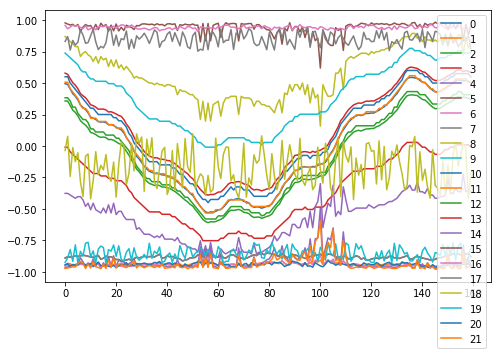

In [14]:
ps[1][0:160].plot(figsize=(8,5))

All that is bit of a mess, so just the first bullet on its own -
* 5 for general bucket/bin statistics: bkt_mean, bkt_std, bkt_std_top, bkt_std_bottom, bkt_range

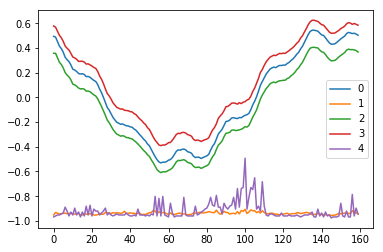

In [15]:
ps[1].iloc[:,0:5][0:160].plot()

Next the diff features:
* 3 for diff/lag in bucket/bin: bkt_diff_mean, bkt_diff_std, bkt_diff_sum

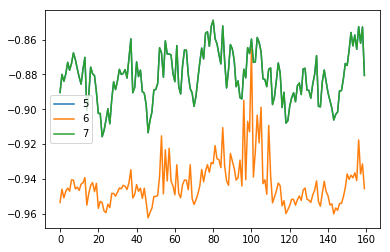

In [16]:
ps[1].iloc[:,5:8][0:160].plot()

Sum and average are overlapping, which is why only 2 lines show. So scaled average is the same as a scaled sum in this case. Should probably look at the othe features more closely as well, but that would be another story.

Next the percentiles:
* 7 percentiles: 0, 1, 25, 50, 75, 99, 100

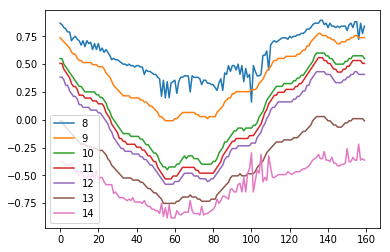

In [17]:
ps[1].iloc[:,8:15][0:160].plot()

And the relative percentiles:
* 7 relative percentiles: 0, 1, 25, 50, 75, 99, 100

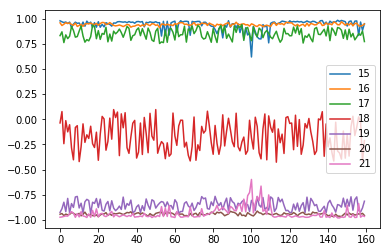

In [18]:
ps[1].iloc[:,15:22][0:160].plot()

## Combined dataset from above single-signal data

The above showed an example for one signal with all the 22 features total.

As another dataset, I combine for each measurement id, the 3 signals into one row as features.

This allows running models where all 3 signals for a measirement id are treated as unified features, such as in the kernel I linked at the beginning.

## Training-dataset combining:

The combine 3 signals code for the training dataset:

In [19]:
measurement_ids = train_meta["id_measurement"].unique()
rows = []
for mid in measurement_ids:
    idx1 = mid*3
    idx2 = idx1 + 1
    idx3 = idx2 + 1
    sig1_idx = idx1 * bkt_count
    sig2_idx = idx2 * bkt_count
    sig3_idx = idx3 * bkt_count
    sig1_data = ps[1][sig1_idx:sig1_idx+bkt_count]
    sig2_data = ps[1][sig2_idx:sig2_idx+bkt_count]
    sig3_data = ps[1][sig3_idx:sig3_idx+bkt_count]
    #this combines the above read 3*160 rows for 3 signals into 1 combined set with with 160 rows
    #and from 22 features on 3*160 to 66 (=22*3) features on 160 rows.
    row = np.concatenate([sig1_data, sig2_data, sig3_data], axis=1).flatten().reshape(bkt_count, sig1_data.shape[1]*3)
    rows.append(row)
df_train_combined = pd.DataFrame(np.vstack(rows))
df_train_combined.to_csv("my_train_combined_scaled.csv.gz", compression="gzip")


### Verification

For verification, a look at the results to check the signal combination has worked:

First the 2 first signals in the single signal dataset:

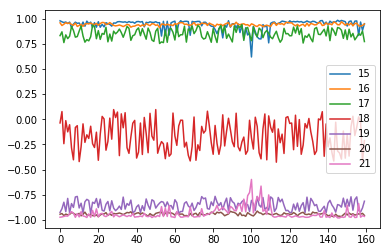

In [20]:
#slot 1 (measurement 1, signal 1, rows 0-159) for single signal version
ps[1].iloc[:,15:22][0:160].plot()

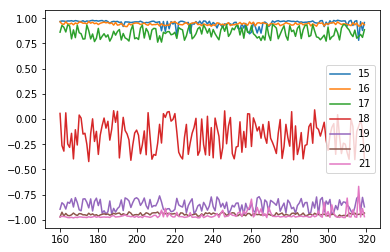

In [21]:
#slot 2 (measurement 1, signal 2, rows 160-319) for single signal version
ps[1].iloc[:,15:22][160:320].plot()

Now the same 2 signals in the combined dataset:

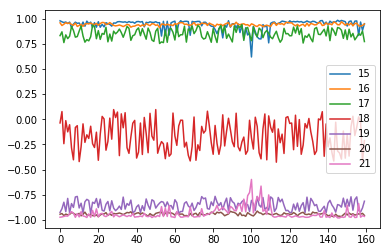

In [22]:
#slot 1 (measurement 1, signal 1) for combined signal version
df_train_combined.iloc[:,15:22][0:160].plot()

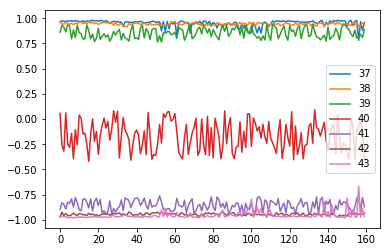

In [23]:
#slot 2 (measurement 1, signal 2) for combined signal version
df_train_combined.iloc[:,37:44][0:160].plot()

One more, a look at the data contents to check also the values:

In [24]:
#signal 1, single signal version
ps[1].iloc[0:4]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.494648,-0.952345,0.357633,0.578792,-0.968254,-0.890359,-0.953549,-0.890387,0.868421,0.738318,0.550,0.506494,0.382716,-0.009618,-0.376623,0.978171,0.957951,0.830951,-0.036067,-0.924594,-0.943128,-0.972498
1,0.489032,-0.931789,0.357123,0.568724,-0.960317,-0.880009,-0.945913,-0.880009,0.855263,0.719626,0.550,0.506494,0.382716,-0.009618,-0.376623,0.968572,0.931391,0.868738,0.076707,-0.888232,-0.935788,-0.969848
2,0.453153,-0.938167,0.321662,0.536424,-0.952381,-0.883973,-0.950927,-0.883973,0.828947,0.700935,0.500,0.454545,0.358025,-0.047710,-0.389610,0.961049,0.944498,0.761889,-0.242179,-0.823483,-0.956541,-0.965129
3,0.415876,-0.944376,0.284918,0.502768,-0.952381,-0.879706,-0.947069,-0.879706,0.815789,0.682243,0.475,0.428571,0.308642,-0.066756,-0.402597,0.966448,0.959437,0.838578,-0.013304,-0.917255,-0.941646,-0.959750


In [25]:
#signal 2, single signal version
ps[1].iloc[160:164]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
160,0.050128,-0.955448,-0.063952,0.160955,-0.960317,-0.899325,-0.959588,-0.899351,0.631579,0.420561,0.125,0.064935,-0.037037,-0.352443,-0.597403,0.968076,0.963942,0.861703,0.055711,-0.895001,-0.970975,-0.970341
161,0.091872,-0.936412,-0.019979,0.195834,-0.960317,-0.888039,-0.951721,-0.888039,0.657895,0.439252,0.175,0.090909,0.012346,-0.295305,-0.571429,0.972821,0.943148,0.929093,-0.262862,-0.830152,-0.924066,-0.965615
162,0.120520,-0.946583,0.004767,0.225175,-0.960317,-0.893872,-0.954185,-0.893872,0.671053,0.457944,0.200,0.116883,0.037037,-0.295305,-0.558442,0.971509,0.939518,0.910460,-0.318470,-0.848082,-0.961506,-0.966921
163,0.153351,-0.948351,0.035436,0.256499,-0.960317,-0.885892,-0.951239,-0.885892,0.684211,0.495327,0.225,0.168831,0.061728,-0.257214,-0.545455,0.968216,0.964328,0.863688,0.061636,-0.893091,-0.936769,-0.970202


In [26]:
#signal 3, single signal version
ps[1].iloc[320:324]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
320,-0.473546,-0.938704,-0.555837,-0.336029,-0.944444,-0.901068,-0.959178,-0.901093,0.355263,0.028037,-0.375,-0.480519,-0.530864,-0.714313,-0.844156,0.958701,0.937998,0.902659,-0.341752,-0.855589,-0.929200,-0.955255
321,-0.498778,-0.934701,-0.578790,-0.360719,-0.960317,-0.882963,-0.948802,-0.882963,0.355263,0.009346,-0.400,-0.506494,-0.555556,-0.733359,-0.870130,0.970653,0.937150,0.898306,-0.354745,-0.859778,-0.930046,-0.967774
322,-0.496144,-0.949265,-0.579702,-0.354851,-0.968254,-0.891271,-0.952558,-0.891271,0.355263,0.009346,-0.400,-0.506494,-0.555556,-0.733359,-0.883117,0.969405,0.933697,0.880579,-0.407650,-0.876837,-0.933489,-0.981231
323,-0.490150,-0.948427,-0.573831,-0.349403,-0.960317,-0.887584,-0.951150,-0.887584,0.355263,0.028037,-0.400,-0.480519,-0.555556,-0.733359,-0.870130,0.966566,0.959762,0.840249,-0.008315,-0.915646,-0.941322,-0.971846


In [27]:
#signal 4 (or signal 1 for measurement id 2))
ps[1].iloc[480:484]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
480,-0.369433,-0.953609,-0.460751,-0.234531,-0.865079,-0.959812,-0.973771,-0.959826,0.355263,0.102804,-0.275,-0.376623,-0.432099,-0.657176,-0.714286,0.909381,0.937218,0.898654,-0.353705,-0.859443,-0.963799,-0.882256
481,-0.346308,-0.950447,-0.438117,-0.213491,-0.801587,-0.956140,-0.958566,-0.956140,0.328947,0.121495,-0.250,-0.350649,-0.407407,-0.638130,-0.636364,0.873907,0.940827,0.917182,-0.298410,-0.841614,-0.960200,-0.819890
482,-0.321365,-0.958425,-0.416367,-0.188150,-0.912698,-0.963816,-0.981268,-0.963816,0.460526,0.158879,-0.225,-0.324675,-0.382716,-0.619084,-0.688312,0.984686,0.975977,0.923485,-0.279597,-0.835548,-0.958976,-0.880515
483,-0.295812,-0.952389,-0.390763,-0.165492,-0.912698,-0.955786,-0.975656,-0.955786,0.434211,0.158879,-0.200,-0.298701,-0.358025,-0.600038,-0.714286,0.948062,0.942483,0.925680,-0.273049,-0.833437,-0.958550,-0.917001


For comparison, the signals 1-3 for measurement id 1 in combined set:

With 22 features, signal 1 from above should be in columns 0-21, signal 2 in columns 22-43, and signal 3 in columns 44-65.

In [28]:
df_train_combined.iloc[0:4]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,0.494648,-0.952345,0.357633,0.578792,-0.968254,-0.890359,-0.953549,-0.890387,0.868421,0.738318,0.550,0.506494,0.382716,-0.009618,-0.376623,0.978171,0.957951,0.830951,-0.036067,-0.924594,-0.943128,-0.972498,0.050128,-0.955448,-0.063952,0.160955,-0.960317,-0.899325,-0.959588,-0.899351,0.631579,0.420561,0.125,0.064935,-0.037037,-0.352443,-0.597403,0.968076,0.963942,0.861703,0.055711,-0.895001,-0.970975,-0.970341,-0.473546,-0.938704,-0.555837,-0.336029,-0.944444,-0.901068,-0.959178,-0.901093,0.355263,0.028037,-0.375,-0.480519,-0.530864,-0.714313,-0.844156,0.958701,0.937998,0.902659,-0.341752,-0.855589,-0.929200,-0.955255
1,0.489032,-0.931789,0.357123,0.568724,-0.960317,-0.880009,-0.945913,-0.880009,0.855263,0.719626,0.550,0.506494,0.382716,-0.009618,-0.376623,0.968572,0.931391,0.868738,0.076707,-0.888232,-0.935788,-0.969848,0.091872,-0.936412,-0.019979,0.195834,-0.960317,-0.888039,-0.951721,-0.888039,0.657895,0.439252,0.175,0.090909,0.012346,-0.295305,-0.571429,0.972821,0.943148,0.929093,-0.262862,-0.830152,-0.924066,-0.965615,-0.498778,-0.934701,-0.578790,-0.360719,-0.960317,-0.882963,-0.948802,-0.882963,0.355263,0.009346,-0.400,-0.506494,-0.555556,-0.733359,-0.870130,0.970653,0.937150,0.898306,-0.354745,-0.859778,-0.930046,-0.967774
2,0.453153,-0.938167,0.321662,0.536424,-0.952381,-0.883973,-0.950927,-0.883973,0.828947,0.700935,0.500,0.454545,0.358025,-0.047710,-0.389610,0.961049,0.944498,0.761889,-0.242179,-0.823483,-0.956541,-0.965129,0.120520,-0.946583,0.004767,0.225175,-0.960317,-0.893872,-0.954185,-0.893872,0.671053,0.457944,0.200,0.116883,0.037037,-0.295305,-0.558442,0.971509,0.939518,0.910460,-0.318470,-0.848082,-0.961506,-0.966921,-0.496144,-0.949265,-0.579702,-0.354851,-0.968254,-0.891271,-0.952558,-0.891271,0.355263,0.009346,-0.400,-0.506494,-0.555556,-0.733359,-0.883117,0.969405,0.933697,0.880579,-0.407650,-0.876837,-0.933489,-0.981231
3,0.415876,-0.944376,0.284918,0.502768,-0.952381,-0.879706,-0.947069,-0.879706,0.815789,0.682243,0.475,0.428571,0.308642,-0.066756,-0.402597,0.966448,0.959437,0.838578,-0.013304,-0.917255,-0.941646,-0.959750,0.153351,-0.948351,0.035436,0.256499,-0.960317,-0.885892,-0.951239,-0.885892,0.684211,0.495327,0.225,0.168831,0.061728,-0.257214,-0.545455,0.968216,0.964328,0.863688,0.061636,-0.893091,-0.936769,-0.970202,-0.490150,-0.948427,-0.573831,-0.349403,-0.960317,-0.887584,-0.951150,-0.887584,0.355263,0.028037,-0.400,-0.480519,-0.555556,-0.733359,-0.870130,0.966566,0.959762,0.840249,-0.008315,-0.915646,-0.941322,-0.971846


And the second bucket at 160-320 rows should have signal 4 (or signal 1 for measurement id 2) from above, in columns 0-21:

In [29]:
df_train_combined.iloc[160:164]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
160,-0.369433,-0.953609,-0.460751,-0.234531,-0.865079,-0.959812,-0.973771,-0.959826,0.355263,0.102804,-0.275,-0.376623,-0.432099,-0.657176,-0.714286,0.909381,0.937218,0.898654,-0.353705,-0.859443,-0.963799,-0.882256,-0.103595,-0.959423,-0.210422,0.017134,-0.944444,-0.964459,-0.984430,-0.964472,0.552632,0.308411,-0.025,-0.090909,-0.185185,-0.466717,-0.649351,0.967341,0.961906,0.851255,0.024530,-0.905056,-0.973005,-0.946647,0.547861,-0.955799,0.407206,0.629701,-0.888889,-0.961075,-0.971403,-0.961089,0.828947,0.775701,0.6,0.558442,0.432099,0.028473,-0.285714,0.916185,0.956045,0.821164,-0.065274,-0.934011,-0.945028,-0.912118
161,-0.346308,-0.950447,-0.438117,-0.213491,-0.801587,-0.956140,-0.958566,-0.956140,0.328947,0.121495,-0.250,-0.350649,-0.407407,-0.638130,-0.636364,0.873907,0.940827,0.917182,-0.298410,-0.841614,-0.960200,-0.819890,-0.125541,-0.958939,-0.231087,-0.003643,-0.912698,-0.963185,-0.979853,-0.963185,0.513158,0.289720,-0.050,-0.116883,-0.209877,-0.466717,-0.636364,0.940959,0.956750,0.824786,-0.054464,-0.930526,-0.944325,-0.924077,0.546355,-0.951482,0.406790,0.627279,-0.809524,-0.955357,-0.949939,-0.955357,0.763158,0.775701,0.6,0.558442,0.432099,0.028473,-0.220779,0.855601,0.958019,0.831299,-0.035028,-0.924259,-0.943060,-0.850341
162,-0.321365,-0.958425,-0.416367,-0.188150,-0.912698,-0.963816,-0.981268,-0.963816,0.460526,0.158879,-0.225,-0.324675,-0.382716,-0.619084,-0.688312,0.984686,0.975977,0.923485,-0.279597,-0.835548,-0.958976,-0.880515,-0.148310,-0.962044,-0.253370,-0.024359,-0.952381,-0.965684,-0.984907,-0.965684,0.513158,0.271028,-0.075,-0.142857,-0.234568,-0.485763,-0.701299,0.951745,0.952673,0.803855,-0.116932,-0.950668,-0.948390,-0.974398,0.545025,-0.961300,0.403235,0.628310,-0.928571,-0.962200,-0.979533,-0.962200,0.842105,0.775701,0.6,0.558442,0.432099,0.028473,-0.337662,0.929788,0.959762,0.840249,-0.008315,-0.915646,-0.941322,-0.959633
163,-0.295812,-0.952389,-0.390763,-0.165492,-0.912698,-0.955786,-0.975656,-0.955786,0.434211,0.158879,-0.200,-0.298701,-0.358025,-0.600038,-0.714286,0.948062,0.942483,0.925680,-0.273049,-0.833437,-0.958550,-0.917001,-0.169236,-0.961923,-0.273153,-0.044092,-0.960317,-0.964952,-0.984355,-0.964952,0.526316,0.252336,-0.075,-0.168831,-0.234568,-0.504809,-0.701299,0.973917,0.946180,0.944660,-0.216402,-0.815172,-0.954863,-0.964523,0.541490,-0.959310,0.400353,0.624518,-0.920635,-0.957629,-0.977632,-0.957629,0.855263,0.775701,0.6,0.558442,0.432099,0.009428,-0.311688,0.943722,0.964396,0.864036,0.062675,-0.892756,-0.970522,-0.933538


All the above checks match, so I judge this as working as intended.

Since this should now all be saved to disk, clean up some memory:

In [30]:
del ps
del df_train_combined

## Test-dataset Processing and Features

Now, the same multiprocessing elements for the test set as above for the training set:

In [31]:
def process_subtest(arg_tuple):
    meta, idx = arg_tuple
    df_sum = summarize_df_np(meta, "test", idx)
    return idx, df_sum

In [32]:
from multiprocessing import Pool

num_cores = 4

def process_test():
    measurement_ids = test_meta["id_measurement"].unique()
    df_split = np.array_split(measurement_ids, num_cores)
    chunk_size = len(df_split[0]) * 3
    
    chunk1 = create_chunk_indices(test_meta, 0, chunk_size)
    chunk2 = create_chunk_indices(test_meta, 1, chunk_size)
    chunk3 = create_chunk_indices(test_meta, 2, chunk_size)
    chunk4 = create_chunk_indices(test_meta, 3, chunk_size)

    all_chunks = [chunk1, chunk2, chunk3, chunk4]
    
    pool = Pool(num_cores)
    result = pool.map(process_subtest, all_chunks)
    result = sorted(result, key=lambda tup: tup[0])

    sums = [item[1] for item in result]

    df_test = pd.concat(sums)
    df_test = df_test.reset_index(drop=True)
    df_test.to_csv("my_test.csv.gz", compression="gzip")

    df_test_scaled = pd.DataFrame(minmax.transform(df_test))
    df_test_scaled.to_csv("my_test_scaled.csv.gz", compression="gzip")
    return df_test, df_test_scaled

In [33]:
pst = process_test()

start/end 1:0,5085
5085
start/end 2:5085,10170
5085
start/end 3:10170,15255
5085
start/end 4:15255,20340
5082


In [34]:
pst[0].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,15.7406,0.855635,16.596235,14.884965,15.0,0.494899,0.650237,2474.0,8.0,14.0,15.0,16.0,16.0,18.0,23.0,-7.7406,-1.7406,-0.7406,0.2594,0.2594,2.2594,7.2594
1,16.7810,0.861997,17.642997,15.919003,16.0,0.511200,0.681670,2556.0,10.0,15.0,16.0,17.0,17.0,19.0,26.0,-6.7810,-1.7810,-0.7810,0.2190,0.2190,2.2190,9.2190
2,17.4658,0.848546,18.314346,16.617254,11.0,0.539400,0.629005,2697.0,12.0,15.0,17.0,18.0,18.0,19.0,23.0,-5.4658,-2.4658,-0.4658,0.5342,0.5342,1.5342,5.5342
3,18.1758,0.743300,18.919100,17.432500,8.0,0.430200,0.579938,2151.0,14.0,16.0,18.0,18.0,19.0,20.0,22.0,-4.1758,-2.1758,-0.1758,-0.1758,0.8242,1.8242,3.8242
4,18.8804,0.773108,19.653508,18.107292,17.0,0.491600,0.754407,2458.0,9.0,17.0,18.0,19.0,19.0,21.0,26.0,-9.8804,-1.8804,-0.8804,0.1196,0.1196,2.1196,7.1196
5,18.5756,0.838501,19.414101,17.737099,5.0,0.532000,0.574957,2660.0,16.0,17.0,18.0,19.0,19.0,20.0,21.0,-2.5756,-1.5756,-0.5756,0.4244,0.4244,1.4244,2.4244
6,18.0568,0.759983,18.816783,17.296817,12.0,0.493400,0.624785,2467.0,12.0,16.0,18.0,18.0,19.0,20.0,24.0,-6.0568,-2.0568,-0.0568,-0.0568,0.9432,1.9432,5.9432
7,17.8750,0.748983,18.623983,17.126017,14.0,0.467200,0.605412,2336.0,12.0,16.0,17.0,18.0,18.0,19.0,26.0,-5.8750,-1.8750,-0.8750,0.1250,0.1250,1.1250,8.1250
8,17.6778,0.762619,18.440419,16.915181,14.0,0.451400,0.613871,2257.0,12.0,16.0,17.0,18.0,18.0,19.0,26.0,-5.6778,-1.6778,-0.6778,0.3222,0.3222,1.3222,8.3222
9,17.0006,0.692676,17.693276,16.307924,6.0,0.436400,0.556017,2182.0,14.0,15.0,17.0,17.0,17.0,19.0,20.0,-3.0006,-2.0006,-0.0006,-0.0006,-0.0006,1.9994,2.9994


In [35]:
pst[1].head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.442361,-0.958006,0.306806,0.530876,-0.896825,-0.966631,-0.977077,-0.966644,0.776316,0.700935,0.500,0.454545,0.333333,-0.047710,-0.350649,0.917124,0.958643,0.834503,-0.025465,-0.921176,-0.942438,-0.923396
1,0.469286,-0.957339,0.332454,0.556073,-0.888889,-0.964573,-0.973930,-0.964573,0.802632,0.719626,0.525,0.480519,0.358025,-0.028664,-0.311688,0.928888,0.957273,0.827468,-0.046461,-0.927945,-0.943804,-0.899462
2,0.487009,-0.958748,0.348903,0.573088,-0.928571,-0.961013,-0.979202,-0.961013,0.828947,0.719626,0.550,0.506494,0.382716,-0.028664,-0.350649,0.945012,0.934043,0.882355,0.117347,-0.875128,-0.966964,-0.944466
3,0.505383,-0.969776,0.363721,0.592954,-0.952381,-0.974800,-0.984113,-0.974800,0.855263,0.738318,0.575,0.506494,0.407407,-0.009618,-0.363636,0.960826,0.943880,0.932854,-0.251637,-0.826533,-0.957156,-0.965351
4,0.523618,-0.966653,0.381715,0.609397,-0.880952,-0.967048,-0.966650,-0.967048,0.789474,0.757009,0.575,0.532468,0.407407,0.009428,-0.311688,0.890891,0.953901,0.810159,-0.098119,-0.944602,-0.947166,-0.925103
5,0.515729,-0.959801,0.375849,0.600377,-0.976190,-0.961947,-0.984612,-0.961947,0.881579,0.757009,0.575,0.532468,0.407407,-0.009618,-0.376623,0.980444,0.964240,0.863235,0.060285,-0.893527,-0.970678,-0.982447
6,0.502303,-0.968028,0.361214,0.589648,-0.920635,-0.966821,-0.979624,-0.966821,0.828947,0.738318,0.575,0.506494,0.407407,-0.009618,-0.337662,0.937766,0.947917,0.953576,-0.189793,-0.806592,-0.953132,-0.939471
7,0.497598,-0.969181,0.356490,0.585486,-0.904762,-0.970129,-0.981563,-0.970129,0.828947,0.738318,0.550,0.506494,0.382716,-0.028664,-0.311688,0.939995,0.954084,0.811099,-0.095312,-0.943697,-0.980804,-0.912824
8,0.492495,-0.967752,0.351992,0.580348,-0.904762,-0.972123,-0.980717,-0.972123,0.828947,0.738318,0.550,0.506494,0.382716,-0.028664,-0.311688,0.942413,0.960773,0.845439,0.007172,-0.910652,-0.974134,-0.910415
9,0.474969,-0.975081,0.333686,0.565550,-0.968254,-0.974017,-0.986507,-0.974017,0.855263,0.719626,0.550,0.480519,0.358025,-0.028664,-0.389610,0.975234,0.949823,0.963362,-0.160586,-0.964744,-0.951231,-0.975424


In [36]:
pst[1].values.shape

(3253920, 22)

## A look at the processed test data

All-in-one figure for the mess:

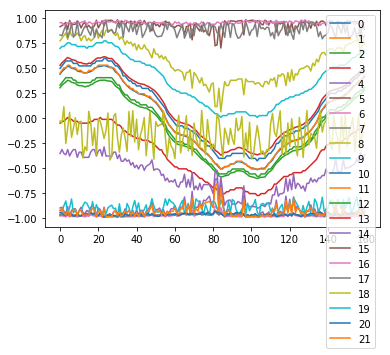

In [37]:
pst[1][0:160].plot()

* The 5 general bucket/bin statistics:

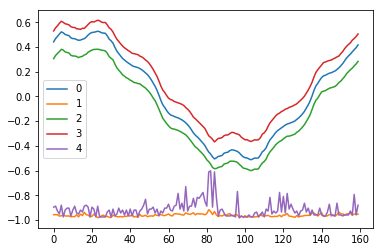

In [38]:
pst[1].iloc[:,0:5][0:160].plot()

* The 3 for diff/lag in bucket/bin:

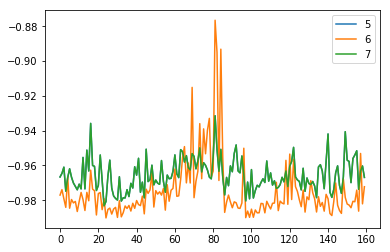

In [39]:
pst[1].iloc[:,5:8][0:160].plot()

* The 7 percentiles:

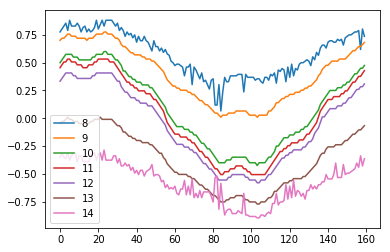

In [40]:
pst[1].iloc[:,8:15][0:160].plot()

* The 7 relative percentiles:

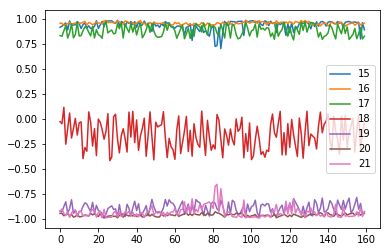

In [41]:
pst[1].iloc[:,15:22][0:160].plot()

## Test-dataset combinations

Similarly, combine 3 signals into one row as features for the combined version for test data:

In [42]:
measurement_ids = test_meta["id_measurement"].unique()
start = measurement_ids[0]
rows = []
for mid in measurement_ids:
    #test measurement id's start from 2904 and indices at 0, so need to align
    mid = mid - start
    idx1 = mid*3
    idx2 = idx1 + 1
    idx3 = idx2 + 1
    sig1_idx = idx1 * bkt_count
    sig2_idx = idx2 * bkt_count
    sig3_idx = idx3 * bkt_count
    sig1_data = pst[1][sig1_idx:sig1_idx+bkt_count]
    sig2_data = pst[1][sig2_idx:sig2_idx+bkt_count]
    sig3_data = pst[1][sig3_idx:sig3_idx+bkt_count]
    row = np.concatenate([sig1_data, sig2_data, sig3_data], axis=1).flatten().reshape(bkt_count, sig1_data.shape[1]*3)
    rows.append(row)
df_test_combined = pd.DataFrame(np.vstack(rows))
df_test_combined.to_csv("my_test_combined_scaled.csv.gz", compression="gzip")


### A look at combined test-dataset

Brief look at the combined test set signals to see it makes sense:

In [43]:
pst[1].iloc[0:4]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.442361,-0.958006,0.306806,0.530876,-0.896825,-0.966631,-0.977077,-0.966644,0.776316,0.700935,0.500,0.454545,0.333333,-0.047710,-0.350649,0.917124,0.958643,0.834503,-0.025465,-0.921176,-0.942438,-0.923396
1,0.469286,-0.957339,0.332454,0.556073,-0.888889,-0.964573,-0.973930,-0.964573,0.802632,0.719626,0.525,0.480519,0.358025,-0.028664,-0.311688,0.928888,0.957273,0.827468,-0.046461,-0.927945,-0.943804,-0.899462
2,0.487009,-0.958748,0.348903,0.573088,-0.928571,-0.961013,-0.979202,-0.961013,0.828947,0.719626,0.550,0.506494,0.382716,-0.028664,-0.350649,0.945012,0.934043,0.882355,0.117347,-0.875128,-0.966964,-0.944466
3,0.505383,-0.969776,0.363721,0.592954,-0.952381,-0.974800,-0.984113,-0.974800,0.855263,0.738318,0.575,0.506494,0.407407,-0.009618,-0.363636,0.960826,0.943880,0.932854,-0.251637,-0.826533,-0.957156,-0.965351


vs.

In [44]:
df_test_combined.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,0.442361,-0.958006,0.306806,0.530876,-0.896825,-0.966631,-0.977077,-0.966644,0.776316,0.700935,0.500,0.454545,0.333333,-0.047710,-0.350649,0.917124,0.958643,0.834503,-0.025465,-0.921176,-0.942438,-0.923396,-0.484886,-0.970699,-0.574055,-0.339267,-0.952381,-0.971405,-0.985986,-0.971416,0.355263,0.028037,-0.400,-0.480519,-0.555556,-0.733359,-0.857143,0.964073,0.952863,0.804830,-0.114021,-0.949729,-0.948201,-0.962117,0.092700,-0.956075,-0.023793,0.201186,-0.896825,-0.968829,-0.977640,-0.968841,0.618421,0.439252,0.175,0.090909,0.012346,-0.314351,-0.506494,0.935650,0.942062,0.923520,-0.279493,-0.835515,-0.958969,-0.904939
1,0.469286,-0.957339,0.332454,0.556073,-0.888889,-0.964573,-0.973930,-0.964573,0.802632,0.719626,0.525,0.480519,0.358025,-0.028664,-0.311688,0.928888,0.957273,0.827468,-0.046461,-0.927945,-0.943804,-0.899462,-0.473484,-0.962099,-0.561249,-0.330530,-0.928571,-0.970659,-0.984156,-0.970659,0.368421,0.046729,-0.375,-0.480519,-0.530864,-0.733359,-0.805195,0.970930,0.971838,0.902241,-0.343000,-0.855991,-0.963102,-0.918645,0.052302,-0.946242,-0.059741,0.160861,-0.904762,-0.965533,-0.976588,-0.965533,0.578947,0.401869,0.125,0.064935,-0.037037,-0.333397,-0.558442,0.918009,0.927171,0.847075,0.012057,-0.909077,-0.939996,-0.934727
2,0.487009,-0.958748,0.348903,0.573088,-0.928571,-0.961013,-0.979202,-0.961013,0.828947,0.719626,0.550,0.506494,0.382716,-0.028664,-0.350649,0.945012,0.934043,0.882355,0.117347,-0.875128,-0.966964,-0.944466,-0.445058,-0.956008,-0.532912,-0.305181,-0.944444,-0.969017,-0.985555,-0.969017,0.368421,0.046729,-0.350,-0.454545,-0.506173,-0.714313,-0.831169,0.957465,0.934579,0.885106,-0.394138,-0.872480,-0.966430,-0.956486,0.005642,-0.943421,-0.103258,0.116270,-0.920635,-0.963412,-0.979175,-0.963412,0.592105,0.383178,0.075,0.012987,-0.086420,-0.371488,-0.571429,0.952372,0.954410,0.812771,-0.090323,-0.942088,-0.946658,-0.924920
3,0.505383,-0.969776,0.363721,0.592954,-0.952381,-0.974800,-0.984113,-0.974800,0.855263,0.738318,0.575,0.506494,0.407407,-0.009618,-0.363636,0.960826,0.943880,0.932854,-0.251637,-0.826533,-0.957156,-0.965351,-0.424267,-0.973481,-0.517313,-0.281540,-0.944444,-0.974042,-0.986222,-0.974042,0.394737,0.084112,-0.325,-0.428571,-0.481481,-0.695267,-0.805195,0.972134,0.975170,0.919341,-0.291965,-0.839536,-0.959781,-0.941872,-0.033203,-0.957767,-0.143390,0.083030,-0.928571,-0.972426,-0.983165,-0.972426,0.565789,0.364486,0.050,-0.038961,-0.111111,-0.409580,-0.610390,0.946255,0.971404,0.900012,-0.349652,-0.858136,-0.963535,-0.943228


Check shape of combined signals to match number of unique measurements in test data:

In [45]:
df_test_combined.shape

(1084640, 66)

## Importing the Results to Other Kernels

To use the kernel output as a dataset in another (e.g., GPU) kernel, create a kernel and select "+ Add Data" on the right side panel.